# Setup

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [3]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

model_path = 'mobilenetv2SoftAtt_10split_LRStr.hdf5'

In [4]:
target_size = (224, 224)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.mobilenet_v3.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [5]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,0,ISIC_0027419,bkl,80.0,male,scalp
1,1,ISIC_0025030,bkl,80.0,male,scalp
2,2,ISIC_0026769,bkl,80.0,male,scalp
3,3,ISIC_0025661,bkl,80.0,male,scalp
4,4,ISIC_0031633,bkl,75.0,male,ear


In [6]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,2973,ISIC_0031531,bcc,70.0,male,back
1,483,ISIC_0026526,bkl,60.0,male,face
2,8870,ISIC_0026805,nv,75.0,female,lower extremity
3,1991,ISIC_0030756,mel,85.0,male,chest
4,8324,ISIC_0024834,nv,70.0,male,chest


## Training Data

In [7]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [8]:
any(elem is None for elem in train_img_lst)

False

In [9]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [10]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [11]:
any(elem is None for elem in val_img_lst)

False

In [12]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 224 224
Example of Age: 70.0
Example of Sex: male
Example of Localization: back


# Model

## Input Block

In [13]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [14]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [15]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding')>

In [16]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_1')>

In [17]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [18]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [19]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [20]:
MobileNetV3Small = tf.keras.applications.MobileNetV3Small(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,

)

inputs['image'] = MobileNetV3Small.input

# Exclude the last 28 layers of the model.
MobileNetV3Small_output = MobileNetV3Small.layers[-28].output

## Final Model

In [21]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(MobileNetV3Small_output.shape[-1]),name='soft_attention')(MobileNetV3Small_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
MobileNetV3Small_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(MobileNetV3Small_output))

MobileNetV3Small_output = layers.Concatenate()([MobileNetV3Small_output, attention_layer])
MobileNetV3Small_output = Activation('relu')(MobileNetV3Small_output)
MobileNetV3Small_output = Dropout(0.5)(MobileNetV3Small_output)

In [22]:
output = Flatten()(MobileNetV3Small_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

 expanded_conv_1/depthwise/Batc  (None, 28, 28, 72)  288         ['expanded_conv_1/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_4 (ReLU)                 (None, 28, 28, 72)   0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 28, 28, 24)  1728        ['re_lu_4[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 28, 28, 24)  96          ['expanded_conv_1/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    2328        ['expanded_conv_3/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__oper

                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 14, 14, 240)  0          ['multiply_4[0][0]',             
 /Mul (Multiply)                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_4/project (Conv2  (None, 14, 14, 40)  9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 14, 14, 40)  160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_

                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 14, 14, 120)  4800       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 14, 14, 120)  480        ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 120)  0          ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
          

                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_7/depthwise (Dep  (None, 14, 14, 144)  3600       ['multiply_9[0][0]']             
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 14, 14, 144)  576        ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 14, 14, 144)  0          ['expanded_conv_7/depthwise/Batch
 ambda)   

 tf.__operators__.add_18 (TFOpL  (None, 7, 7, 288)   0           ['expanded_conv_8/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_23 (ReLU)                (None, 7, 7, 288)    0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 7, 7, 288)   0           ['re_lu_23[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_12 (Multiply)         (None, 7, 7, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
          

 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   0           ['expanded_conv_9/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
          

                                                                                                  
 string_lookup_1 (StringLookup)  (None, 1)           0           ['localization[0][0]']           
                                                                                                  
 activation (Activation)        (None, 4, 4, 1152)   0           ['concatenate_1[0][0]']          
                                                                                                  
 normalization (Normalization)  (None, 1)            3           ['age[0][0]']                    
                                                                                                  
 category_encoding (CategoryEnc  (None, 4)           0           ['string_lookup[0][0]']          
 oding)                                                                                           
                                                                                                  
 category_

## Training

In [24]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [25]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [26]:
class_weights = { 
                    0: 4.37,  # akiec
                    1: 2.78,  # bcc
                    2: 1.3,  # bkl
                    3: 12.44,  # df
                    4: 1.28,  # mel
                    5: 0.21,  # nv
                    6: 10,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [27]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [29]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500,
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 615s 617ms/step - loss: 2.9783 - accuracy: 0.4757 - val_loss: 2.5708 - val_accuracy: 0.6988 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 499s 556ms/step - loss: 1.6480 - accuracy: 0.5664 - val_loss: 4.3707 - val_accuracy: 0.4327 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 529s 590ms/step - loss: 1.0297 - accuracy: 0.6357 - val_loss: 1.0010 - val_accuracy: 0.7149 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 533s 594ms/step - loss: 0.8547 - accuracy: 0.6711 - val_loss: 3.9647 - val_accuracy: 0.5422 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 527s 588ms/step - loss: 0.7688 - accuracy: 0.7037 - val_loss: 0.9248 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 539s 602ms/step - loss: 0.6232 - accuracy: 0.7239 - val_loss: 1.1249 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 7/500
896/896 [===================

896/896 [==============================] - 494s 551ms/step - loss: 0.4072 - accuracy: 0.7907 - val_loss: 0.6115 - val_accuracy: 0.7721 - lr: 3.2000e-07
Epoch 47/500
896/896 [==============================] - 494s 551ms/step - loss: 0.4055 - accuracy: 0.7879 - val_loss: 0.6126 - val_accuracy: 0.7721 - lr: 3.2000e-07
Epoch 48/500
897/896 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.7941
Epoch 48: ReduceLROnPlateau reducing learning rate to 1e-07.
896/896 [==============================] - 503s 561ms/step - loss: 0.3743 - accuracy: 0.7941 - val_loss: 0.6139 - val_accuracy: 0.7691 - lr: 3.2000e-07
Epoch 49/500
896/896 [==============================] - 500s 557ms/step - loss: 0.3713 - accuracy: 0.7916 - val_loss: 0.6125 - val_accuracy: 0.7711 - lr: 1.0000e-07
Epoch 50/500
896/896 [==============================] - 521s 581ms/step - loss: 0.3775 - accuracy: 0.7884 - val_loss: 0.6148 - val_accuracy: 0.7691 - lr: 1.0000e-07
Epoch 51/500
896/896 [====================

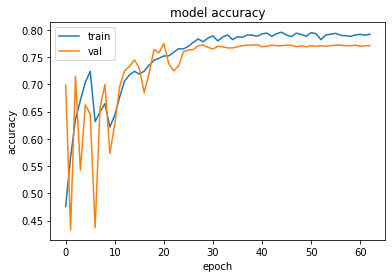

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

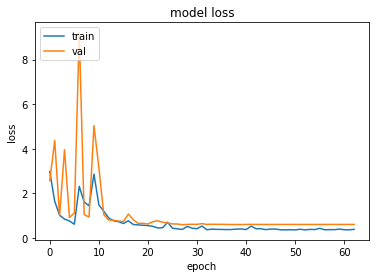

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
from tensorflow.keras import models
model.load_weights(model_path)

In [33]:
batch_size = 32 
predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

# Classification report

In [34]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.50      0.76      0.60        33
         bcc       0.62      0.84      0.72        51
         bkl       0.55      0.68      0.61       109
          df       0.60      1.00      0.75        12
         mel       0.42      0.52      0.47       111
          nv       0.96      0.82      0.89       666
        vasc       0.81      0.93      0.87        14

    accuracy                           0.78       996
   macro avg       0.64      0.79      0.70       996
weighted avg       0.82      0.78      0.79       996



# Confusion Matrix Metrics

In [35]:
from sklearn.metrics import multilabel_confusion_matrix
multi_cm = multilabel_confusion_matrix(y_true, y_pred)
#print(multi_cm)

# TN     FP
# FN     TP

In [36]:
def cm_compute(_cm, _index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

### akiec       

In [37]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of akiec
[[938  25]
 [  8  25]]
True Positive of akiec: 25
False Positive of akiec: 25
False Negative of akiec: 8
True Negative of akiec: 938
Sensitivity of akiec: 0.7575757575757576
Specificity of akiec: 0.9740394600207685
Precision of akiec: 0.5
Accuracy of akiec: 0.9668674698795181
Balanced Accuracy of akiec : 0.865807608798263
F1 Score of akiec: 0.6024096385542169


### bcc       

In [38]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bcc
[[919  26]
 [  8  43]]
True Positive of bcc: 43
False Positive of bcc: 26
False Negative of bcc: 8
True Negative of bcc: 919
Sensitivity of bcc: 0.8431372549019608
Specificity of bcc: 0.9724867724867725
Precision of bcc: 0.6231884057971014
Accuracy of bcc: 0.9658634538152611
Balanced Accuracy of bcc : 0.9078120136943666
F1 Score of bcc: 0.7166666666666667


### bkl

In [39]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bkl
[[827  60]
 [ 35  74]]
True Positive of bkl: 74
False Positive of bkl: 60
False Negative of bkl: 35
True Negative of bkl: 827
Sensitivity of bkl: 0.6788990825688074
Specificity of bkl: 0.9323562570462233
Precision of bkl: 0.5522388059701493
Accuracy of bkl: 0.9046184738955824
Balanced Accuracy of bkl : 0.8056276698075153
F1 Score of bkl: 0.6090534979423868


### df 

In [40]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of df
[[976   8]
 [  0  12]]
True Positive of df: 12
False Positive of df: 8
False Negative of df: 0
True Negative of df: 976
Sensitivity of df: 1.0
Specificity of df: 0.991869918699187
Precision of df: 0.6
Accuracy of df: 0.9919678714859438
Balanced Accuracy of df : 0.9959349593495934
F1 Score of df: 0.75


### mel

In [41]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of mel
[[805  80]
 [ 53  58]]
True Positive of mel: 58
False Positive of mel: 80
False Negative of mel: 53
True Negative of mel: 805
Sensitivity of mel: 0.5225225225225225
Specificity of mel: 0.9096045197740112
Precision of mel: 0.42028985507246375
Accuracy of mel: 0.8664658634538153
Balanced Accuracy of mel : 0.7160635211482669
F1 Score of mel: 0.46586345381526106


### nv

In [42]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of nv
[[308  22]
 [119 547]]
True Positive of nv: 547
False Positive of nv: 22
False Negative of nv: 119
True Negative of nv: 308
Sensitivity of nv: 0.8213213213213213
Specificity of nv: 0.9333333333333333
Precision of nv: 0.961335676625659
Accuracy of nv: 0.858433734939759
Balanced Accuracy of nv : 0.8773273273273273
F1 Score of nv: 0.8858299595141701


### vasc

In [43]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of vasc
[[979   3]
 [  1  13]]
True Positive of vasc: 13
False Positive of vasc: 3
False Negative of vasc: 1
True Negative of vasc: 979
Sensitivity of vasc: 0.9285714285714286
Specificity of vasc: 0.9969450101832994
Precision of vasc: 0.8125
Accuracy of vasc: 0.9959839357429718
Balanced Accuracy of vasc : 0.962758219377364
F1 Score of vasc: 0.8666666666666667


## Weighted, Macro, Micro, ROC AUC

In [44]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8172222621406936
Recall: 0.7751004016064257
Accuracy: 0.7751004016064257
weighted Roc score: 0.9427761454336527


In [45]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.6385075347807677
Recall: 0.793146766780257
Accuracy: 0.7751004016064257
Macro Roc score: 0.9590467144491361


In [46]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.7751004016064257
Recall: 0.7751004016064257
Accuracy: 0.7751004016064257
Micro Roc score: 0.9703038223845851


In [47]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9776267346360804
The ROC AUC score of bcc is: 0.9784832451499118
The ROC AUC score of bkl is: 0.9314874383293857
The ROC AUC score of df is: 0.9986449864498645
The ROC AUC score of mel is: 0.8797271848119306
The ROC AUC score of nv is: 0.9484848484848485
The ROC AUC score of vasc is: 0.9988725632819319


In [48]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

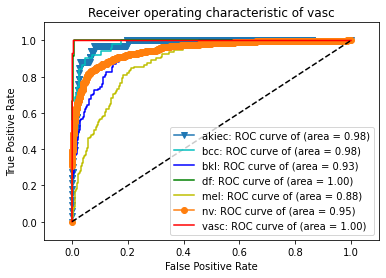

In [49]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()